# Outliers

1. Drop outliers 
2. Fill with a value
3. Truncate 

In [1]:
import pandas as pd
from matplotlib.pyplot import figure, show
from sklearn.impute import SimpleImputer
import dslabs_functions as dslabs
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import savefig
from sklearn.impute import KNNImputer

filename = '../data_preparation_csvs/mv_imputation_csvs/data_mv_alt2.csv'
data_encoded: pd.DataFrame = pd.read_csv(filename, sep=',', decimal='.', na_values='')
print(f"Dataset nr records={data_encoded.shape[0]}", f"nr variables={data_encoded.shape[1]}")
outlier_vars = ["Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "NumofLoan", "Delay_from_due_date", "NumofDelayedPayment", "ChangedCreditLimit", "NumCreditInquiries", "OutstandingDebt", "CreditUtilizationRatio", "Credit_History_Age", "TotalEMIpermonth", "Amountinvestedmonthly", "MonthlyBalance"]

Dataset nr records=100000 nr variables=32


In [2]:
# Save to file
def save(df, name):
    df.to_csv(f'../data_preparation_csvs/outliers_treatment_csvs/outliers_{name}_data.csv', index=False)

    ## Separate into Train and Test and save in different files
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

    ## Save the training and testing sets to CSV files
    train_data.to_csv(f'../data_preparation_csvs/outliers_treatment_csvs/train_data_mv_{name}.csv', index=False)
    test_data.to_csv(f'../data_preparation_csvs/outliers_treatment_csvs/test_data_mv_{name}.csv', index=False)

    ## Evaluate Approach
    file_tag = "Credit_Score"
    target = "Credit_Score"

    figure()
    eval: dict[str, list] = dslabs.evaluate_approach(train_data, test_data, target=target, metric="recall")
    dslabs.plot_multibar_chart(
        ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
    )
    savefig(f"../data_preparation_images/outliers_treatment_result/data_mv_{name}_eval.png")
    show()

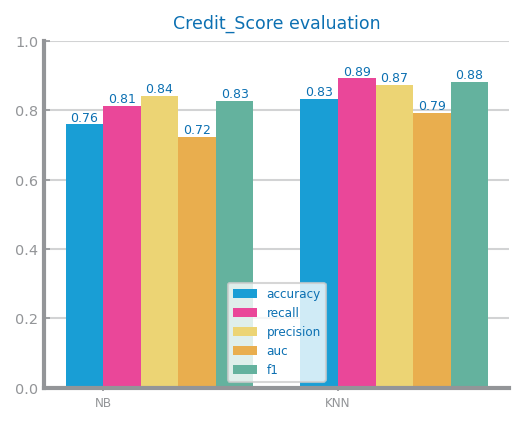

In [3]:
# Drop outliers

n_std: int = dslabs.NR_STDEV
df: pd.DataFrame = data_encoded.copy(deep=True)
summary5: pd.DataFrame = data_encoded[outlier_vars].describe()
for var in outlier_vars:
    top_threshold, bottom_threshold = dslabs.determine_outlier_thresholds_for_var(
        summary5[var],
        std_based=True,
        threshold=3 
    )
    outliers: pd.Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
    df.drop(outliers.index, axis=0, inplace=True)

save(df, "alt1")

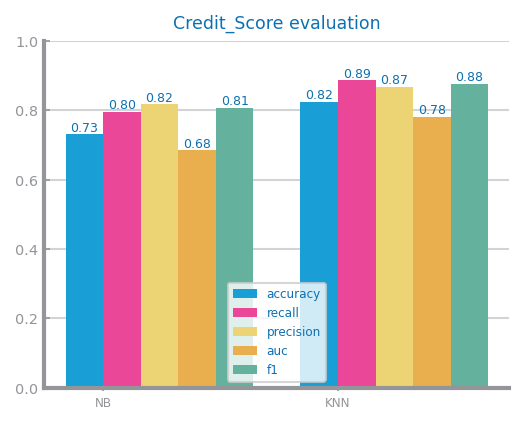

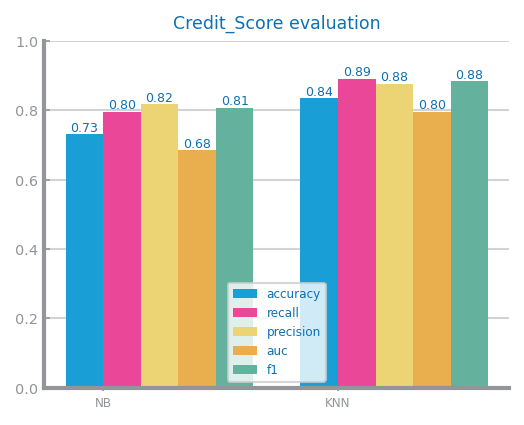

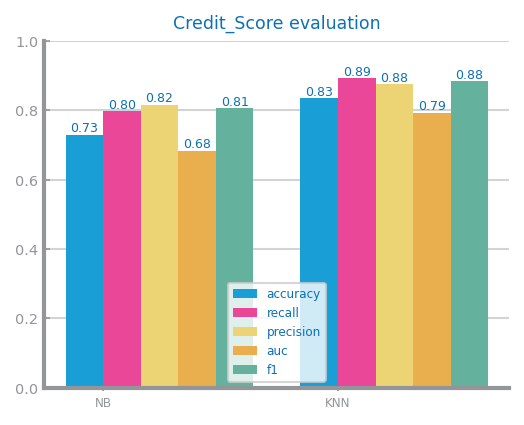

In [4]:
# Fill with values - [mean, median, mode] - Median wins
for strategy in ["mean", "median", "mode"]:
    df: pd.DataFrame = data_encoded.copy(deep=True)
    summary5: pd.DataFrame = data_encoded[outlier_vars].describe()
    for var in outlier_vars:
        top, bottom = dslabs.determine_outlier_thresholds_for_var(summary5[var])
        if strategy == "mean":
            stat: float = df[var].mean()
        if strategy == "median":
            stat: float = df[var].median()
        if strategy == "mode":
            stat: int | float = df[var].mode()[0]
        df[var] = df[var].apply(lambda x: stat if x > top or x < bottom else x)
    save(df, f"alt2_{strategy}")

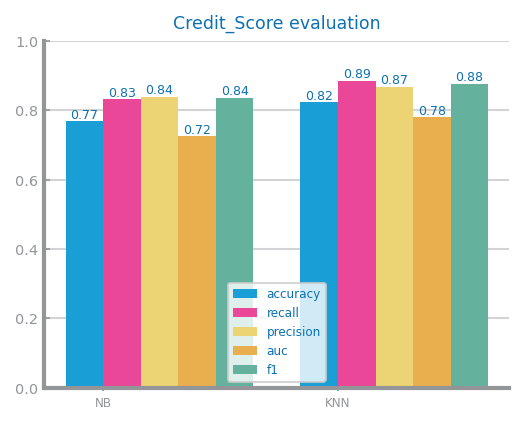

In [5]:
# Truncate - replace outliers with "max" and "min" - Analysis
df: pd.DataFrame = data_encoded.copy(deep=True)
for var in outlier_vars:
    top, bottom = dslabs.determine_outlier_thresholds_for_var(summary5[var])
    df[var] = df[var].apply(
        lambda x: top if x > top else bottom if x < bottom else x
    )

save(df, "alt3")